# **SimpleCNN**
The `SimpleCNN` class implements a Convolutional Neural Network (CNN) architecture designed for tasks that focus on mesoscopic image proporties, often used in image forensics, such as deepfake detection. This network is based on the principles of the **Meso-4** architecture, a variant of the original **MesoNet** proposed by Afchar et al.

## **Architecture Breakdown**
### **1. Convolutional Blocks**
Each block follows a consistent Pattern: **Convolution** &rarr; **Batch Normalization** &rarr; **ReLU Activation** &rarr; **Max Pooling**
|Block|Input Channels|Output Channels|Kernel Size|Max Pool Size|Output Size (HxW)|Purpose|
|---|---|---|---|---|---|---|
|**Block 1**|3|8|3x3|2x2|128x128|Initial feature extraction|
|**Block 2**|8|8|3x3|2x2|64x64|Further feature extraction|
|**Block 3**|8|16|5x5|2x2|32x32|Increased filter size of wider context|
|**Block 4**|16|16|5x5|2x2|16x16|Final feature map preparation|

* **Batch Normalization (`nn.BatchNorm2d`)**: used after each convolutiona to stablize and accelerate training.
* **Activation (`nn.ReLU`)**: The Rectified Linear Unit is used for non-linearity in the convolutional layers.

### **2. Classifier**
The convolutional feature maps are processed by a fully connected (FC) classifier.
- **Flatten**: The final 3D feature map (16 channels, 16x16 size) is flattened into a vector of size $16\times 16\times 16 = 4096$
- **Hidden Layer (`nn.Linear`)**: A fully connected layer maps the features to **16 units**.
- **Activation (`nn.LeakyReLU`)**: The Leaky ReLU (with a negative slope of 0.1) is used as the activation function for the hidden layer.
- **Regularization (`nn.Dropout`)**: A Dropout layer with $p=0.5$ is applied to prevent over fitting.
- **Output Layer (`nn.Layer`)**: The final fully connected layer maps the 16 units to the number of output classes (`num_classes`).

## **Training Process**

### **Import Libraries**

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [25]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)

In [26]:
from src.dataloader import get_data_loaders
from src.model import SimpleCNN
from src.utils import set_seed, train_one_epoch, evaluate, save_checkpoint, save_experiment_json, get_device, performance

### **Configurations**

In [27]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results'
MODEL_NAME = 'simpleCNN'
TASK_NAME = 'deepfake_detection_aug'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device(get_device())
BENCHMARK = torch.backends.cudnn.benchmark = True
set_seed(42)

In [28]:
print(f"Project Root: {root_name}")
print(f"Device: {DEVICE}")
print(f"Benchmark: {BENCHMARK}")

Project Root: deep_fake_detection
Device: cuda
Benchmark: True


### **Getting DataLoaders**

- The preprocessing process is located in `src.preprocessing`.
- The Dataset and DataLoader process is located in `src.dataloader`.

In [29]:
train_loader, valid_loader = get_data_loaders(DATA_ROOT, MODEL_NAME, BATCH_SIZE)

Class expected: ['real', 'fake']
Class found: {'real', 'fake'}


### **Model Initialization**
- Model's architecture is located in `src.model`

In [32]:
import torchsummary

model = SimpleCNN(num_classes=2).to(DEVICE)
torchsummary.summary(model, (3, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 8, 256, 256]             216
       BatchNorm2d-2          [32, 8, 256, 256]              16
              ReLU-3          [32, 8, 256, 256]               0
         MaxPool2d-4          [32, 8, 128, 128]               0
            Conv2d-5          [32, 8, 130, 130]             576
       BatchNorm2d-6          [32, 8, 130, 130]              16
              ReLU-7          [32, 8, 130, 130]               0
         MaxPool2d-8            [32, 8, 65, 65]               0
            Conv2d-9           [32, 16, 65, 65]           3,200
      BatchNorm2d-10           [32, 16, 65, 65]              32
             ReLU-11           [32, 16, 65, 65]               0
        MaxPool2d-12           [32, 16, 32, 32]               0
           Conv2d-13           [32, 16, 32, 32]           6,400
      BatchNorm2d-14           [32, 16,

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [10]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [], "val_losses": [],
    "train_accuracy": [], "val_accuracy": [],
    "val_f1": [], "val_auc": [],
    "EPOCHS": EPOCHS,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

### **Training & Evaluating**

In [11]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


[1/30] train_acc: 0.4965 - train_loss: 0.7012 - valid_acc: 0.5443 - valid_loss: 0.6926
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 1 - acc: 0.5443



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]


[2/30] train_acc: 0.4996 - train_loss: 0.6941 - valid_acc: 0.5000 - valid_loss: 0.6931
	- [current best] epoch: 1 - acc: 0.5443



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.64it/s]


[3/30] train_acc: 0.4969 - train_loss: 0.6934 - valid_acc: 0.5000 - valid_loss: 0.6929
	- [current best] epoch: 1 - acc: 0.5443



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]


[4/30] train_acc: 0.5235 - train_loss: 0.6922 - valid_acc: 0.5920 - valid_loss: 0.6819
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 4 - acc: 0.5920



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]


[5/30] train_acc: 0.5655 - train_loss: 0.6803 - valid_acc: 0.6180 - valid_loss: 0.6560
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 5 - acc: 0.6180



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.56it/s]


[6/30] train_acc: 0.5780 - train_loss: 0.6718 - valid_acc: 0.6255 - valid_loss: 0.6521
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 6 - acc: 0.6255



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]


[7/30] train_acc: 0.5926 - train_loss: 0.6660 - valid_acc: 0.6348 - valid_loss: 0.6411
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 7 - acc: 0.6348



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.70it/s]


[8/30] train_acc: 0.5958 - train_loss: 0.6619 - valid_acc: 0.6268 - valid_loss: 0.6431
	- [current best] epoch: 7 - acc: 0.6348



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


[9/30] train_acc: 0.5960 - train_loss: 0.6583 - valid_acc: 0.6338 - valid_loss: 0.6331
	- [current best] epoch: 7 - acc: 0.6348



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


[10/30] train_acc: 0.6000 - train_loss: 0.6539 - valid_acc: 0.6400 - valid_loss: 0.6294
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 10 - acc: 0.6400



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


[11/30] train_acc: 0.6077 - train_loss: 0.6495 - valid_acc: 0.6465 - valid_loss: 0.6266
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 11 - acc: 0.6465



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


[12/30] train_acc: 0.6110 - train_loss: 0.6450 - valid_acc: 0.6482 - valid_loss: 0.6202
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 12 - acc: 0.6482



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.30it/s]


[13/30] train_acc: 0.6171 - train_loss: 0.6413 - valid_acc: 0.6575 - valid_loss: 0.6122
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 13 - acc: 0.6575



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.52it/s]


[14/30] train_acc: 0.6255 - train_loss: 0.6341 - valid_acc: 0.6603 - valid_loss: 0.6063
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 14 - acc: 0.6603



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.57it/s]


[15/30] train_acc: 0.6276 - train_loss: 0.6325 - valid_acc: 0.6605 - valid_loss: 0.6047
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 15 - acc: 0.6605



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.61it/s]


[16/30] train_acc: 0.6307 - train_loss: 0.6278 - valid_acc: 0.6402 - valid_loss: 0.6231
	- [current best] epoch: 15 - acc: 0.6605



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.93it/s]


[17/30] train_acc: 0.6416 - train_loss: 0.6220 - valid_acc: 0.6593 - valid_loss: 0.6004
	- [current best] epoch: 15 - acc: 0.6605



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


[18/30] train_acc: 0.6400 - train_loss: 0.6202 - valid_acc: 0.6797 - valid_loss: 0.5976
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 18 - acc: 0.6797



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.28it/s]


[19/30] train_acc: 0.6465 - train_loss: 0.6143 - valid_acc: 0.6745 - valid_loss: 0.5901
	- [current best] epoch: 18 - acc: 0.6797



Evaluating: 100%|██████████| 125/125 [00:15<00:00,  7.92it/s]


[20/30] train_acc: 0.6504 - train_loss: 0.6112 - valid_acc: 0.6720 - valid_loss: 0.5989
	- [current best] epoch: 18 - acc: 0.6797



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


[21/30] train_acc: 0.6542 - train_loss: 0.6090 - valid_acc: 0.6800 - valid_loss: 0.5973
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:15<00:00,  8.19it/s]


[22/30] train_acc: 0.6595 - train_loss: 0.6057 - valid_acc: 0.6733 - valid_loss: 0.5966
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]


[23/30] train_acc: 0.6603 - train_loss: 0.6021 - valid_acc: 0.6780 - valid_loss: 0.5876
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.59it/s]


[24/30] train_acc: 0.6638 - train_loss: 0.5999 - valid_acc: 0.6777 - valid_loss: 0.5844
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  6.99it/s]


[25/30] train_acc: 0.6681 - train_loss: 0.5938 - valid_acc: 0.6717 - valid_loss: 0.6003
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


[26/30] train_acc: 0.6702 - train_loss: 0.5936 - valid_acc: 0.6725 - valid_loss: 0.5943
	- [current best] epoch: 21 - acc: 0.6800



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.67it/s]


[27/30] train_acc: 0.6729 - train_loss: 0.5869 - valid_acc: 0.6933 - valid_loss: 0.5908
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 27 - acc: 0.6933



Evaluating: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


[28/30] train_acc: 0.6793 - train_loss: 0.5824 - valid_acc: 0.6993 - valid_loss: 0.5757
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 28 - acc: 0.6993



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


[29/30] train_acc: 0.6802 - train_loss: 0.5815 - valid_acc: 0.6930 - valid_loss: 0.5770
	- [current best] epoch: 28 - acc: 0.6993



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.04it/s]

[30/30] train_acc: 0.6799 - train_loss: 0.5796 - valid_acc: 0.6890 - valid_loss: 0.5801
	- [current best] epoch: 28 - acc: 0.6993



### **Performance Evaluation**

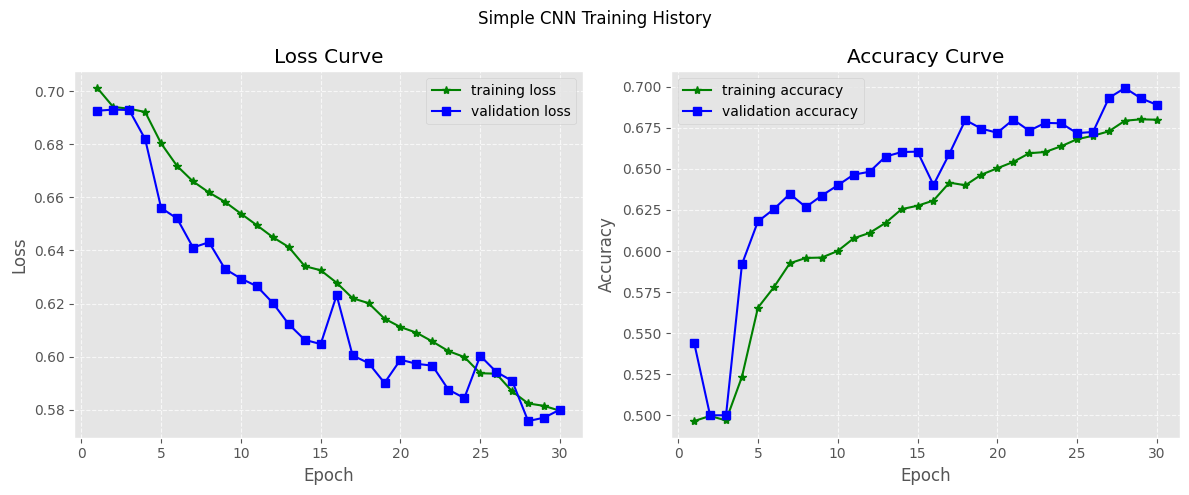

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"../results/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [22]:
json_filename = f"../results/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simpleCNN_deepfake_detection_aug.json


Accuracy score: 0.6890


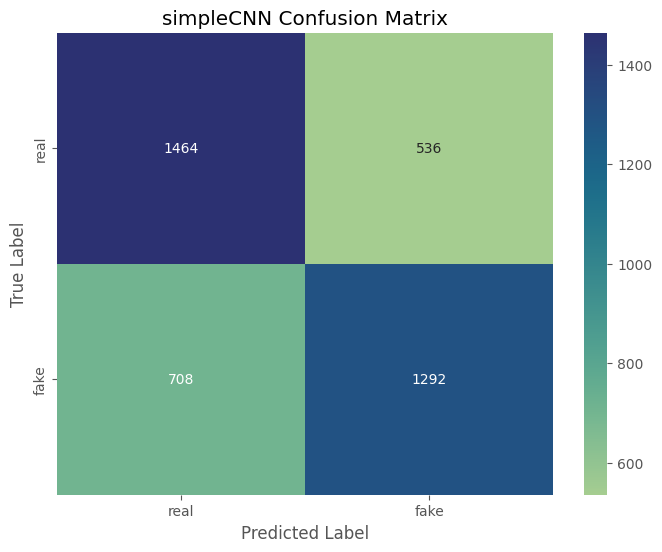

In [ ]:
from src.utils import performance
performance(model, valid_loader, DEVICE, MODEL_NAME, TASK_NAME)